Patrick Jean-Baptiste

The CUNY Graduate Center

# Description: Visual Pre-Trained Model

This notebook employs a pre-trained VGG16 model for recognizing emotions in images. The VGG16 model is pre-loaded with weights trained on ImageNet. The images of actors' faces expressing an emotion were extracted in a previous notebook.

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from get_data import get_data
from match_files import match_files

Retrieve the images of the actors' faces expressing an emotion along with the corresponding labels that indicate the type of emotion expressed in the images.

In [2]:
img_dir = "Emotion_Images"
Emotion_Images = []
Emotion_Labels = []
Emotion_File_Names = []

for idx, img_file in enumerate(os.listdir(img_dir)):

    # Read an image of an actor's face expressing an emotion.
    img = cv2.imread(os.path.join(img_dir, img_file))

    # Increase the size of the image.
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
  
    # Append the image of an expressed emotion to an array.
    Emotion_Images.append(img)

    # Append the label indicating the type of emotion 
    # expressed to an array.
    Emotion_Labels.append(int(img_file[7]))

    # Append the name of the file that contains the image.
    Emotion_File_Names.append(img_file)


Emotion_Images = np.array(Emotion_Images)  
Emotion_Labels = np.array(Emotion_Labels)
Emotion_File_Names = np.array(Emotion_File_Names)
img_size = Emotion_Images.shape[1]

# Convert the labels into a one-hot array.
Labels_One_Hot = np.zeros((len(Emotion_Labels), 8))

for i in range(len(Emotion_Labels)):
     Labels_One_Hot[i,(Emotion_Labels[i] - 1)] = 1 
    
    
Labels_One_Hot = Labels_One_Hot.astype(int)

Print the shape of the array containing the images of expressed emotion.

In [3]:
print(Emotion_Images.shape)

(4902, 224, 224, 3)


Print the shape of the array containing the labels that correspond to the types of emotion expressed.

In [4]:
print(Emotion_Labels.shape)

(4902,)


Split the audio emotion data into a train, validation, and test set. 

In [5]:
train = pd.read_csv("DatasetSplitCSV/train.csv",header=None)
val = pd.read_csv("DatasetSplitCSV/valid.csv",header=None)
test = pd.read_csv("DatasetSplitCSV/test.csv",header=None)

In [6]:
train.describe()

,0,1
count,1470,1470
unique,1470,8
top,03-01-05-02-02-02-24.wav,sad
freq,1,232


In [7]:
val.describe()

,0,1
count,491,491
unique,491,8
top,03-01-05-01-01-02-08.wav,happy
freq,1,88


In [8]:
test.describe()

,0,1
count,491,491
unique,491,8
top,03-02-05-02-02-02-09.wav,calm
freq,1,78


Retrieve the names of the image files along with the corresponding labels that correlate to the train, validation, and test sets from the audio emotion data.

In [9]:
train_files, train_labels = get_data(train)
val_files, val_labels = get_data(val)
test_files, test_labels = get_data(test)

Match the image file names with the images of expressed emotion in order to create the train, validation, and test sets for visual emotion.

In [10]:
X_train, y_train = match_files(Emotion_File_Names, Emotion_Images, Emotion_Labels, train_files)
X_val, y_val = match_files(Emotion_File_Names, Emotion_Images, Emotion_Labels, val_files)
X_test, y_test = match_files(Emotion_File_Names, Emotion_Images, Emotion_Labels, test_files)

Import the VGG16 model pre-loaded with weights trained on ImageNet.

In [11]:
vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

Print each layer of the VGG16 model.

In [12]:
for layer in (vgg16_model.layers):
    layer.trainable = False
    print(layer)

Create the visual pre-trained model.

In [13]:
visual_pre_trained_model = tf.keras.Model(inputs=vgg16_model.input, 
                            outputs=tf.keras.layers.Dense(8, activation="softmax")(vgg16_model.layers[-2].output))

Print the summary of the visual pre-trained model.

In [14]:
visual_pre_trained_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Compile the visual pre-trained model.

In [15]:
visual_pre_trained_model.compile(loss='mse', 
                        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
                        metrics=['mse', 'RootMeanSquaredError', 'mae', 'accuracy']) 

Train the visual pre-trained model.

In [16]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

history = visual_pre_trained_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=100, 
                                   callbacks=[early])

Train on 2824 samples, validate on 942 samples
Epoch 1/5
2824/2824 [==============================] - 1484s 526ms/sample - loss: 0.1158 - mse: 0.1158 - RootMeanSquaredError: 0.3403 - mae: 0.2134 - accuracy: 0.1863 - val_loss: 0.1081 - val_mse: 0.1081 - val_RootMeanSquaredError: 0.3288 - val_mae: 0.2076 - val_accuracy: 0.2335
Epoch 2/5
2824/2824 [==============================] - 1340s 475ms/sample - loss: 0.1068 - mse: 0.1068 - RootMeanSquaredError: 0.3268 - mae: 0.2053 - accuracy: 0.2574 - val_loss: 0.1049 - val_mse: 0.1049 - val_RootMeanSquaredError: 0.3238 - val_mae: 0.2044 - val_accuracy: 0.2643
Epoch 3/5
2824/2824 [==============================] - 1404s 497ms/sample - loss: 0.1040 - mse: 0.1040 - RootMeanSquaredError: 0.3225 - mae: 0.2019 - accuracy: 0.2886 - val_loss: 0.1016 - val_mse: 0.1016 - val_RootMeanSquaredError: 0.3188 - val_mae: 0.2003 - val_accuracy: 0.3174
Epoch 4/5
2824/2824 [==============================] - 1331s 471ms/sample - loss: 0.1021 - mse: 0.1021 - RootMean

Plot the training mean squared error, root mean squared error, mean absolute error, and accuracy for the visual pre-trained model.

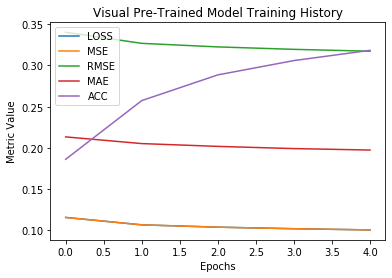

In [17]:
plt.title('Visual Pre-Trained Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.plot(history.history['loss'], label='LOSS')
plt.plot(history.history['mse'], label='MSE')
plt.plot(history.history['RootMeanSquaredError'], label='RMSE')
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['accuracy'], label='ACC')
plt.legend()
plt.show()

Plot the validation mean squared error, root mean squared error, mean absolute error, and accuracy for the visual pre-trained model.

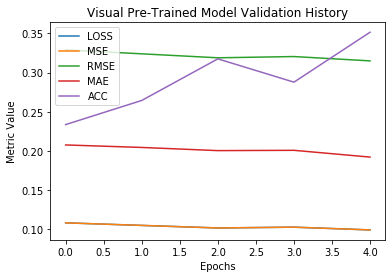

In [18]:
plt.title('Visual Pre-Trained Model Validation History')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.plot(history.history['val_loss'], label='LOSS')
plt.plot(history.history['val_mse'], label='MSE')
plt.plot(history.history['val_RootMeanSquaredError'], label='RMSE')
plt.plot(history.history['val_mae'], label='MAE')
plt.plot(history.history['val_accuracy'], label='ACC')
plt.legend()
plt.show()

Evaluate the visual pre-trained model.

In [19]:
scores = visual_pre_trained_model.evaluate(X_test, y_test)

948/948 [==============================] - 341s 359ms/sample - loss: 0.1014 - mse: 0.1014 - RootMeanSquaredError: 0.3184 - mae: 0.1943 - accuracy: 0.3143


The pre-trained VGG16 model did slightly improve the emotion recognition accuarcy compared to best visual model in the previous notebook, which was the second visual model. Since the VGG16 model is pre-trained on a large number of images, that could have led to the increase in emotion recognition accuracy. Increasing the number epochs for training could further improve the emotion recognition performance. Regardless, the second visual model and the pre-trained VGG16 model produced poor results for visual emotion recognition. 